INFO:__main__:Best Decision Tree Parameters: {'max_depth': 10, 'min_samples_split': 2}
INFO:__main__:Decision Tree - MSE: 7.812500000000014e-07, MAE: 0.00031250000000000293, R2: 0.9980571914273572
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\Krishan\AppData\Local\Temp\tmpbkmhk6tj\pyqctsvr.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Krishan\AppData\Local\Temp\tmpbkmhk6tj\yk7cro57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Krishan\\AppData\\Roaming\\Python\\Python312\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=87139', 'data', 'file=C:\\Users\\Krishan\\AppData\\Local\\Temp\\tmpbkmhk6tj\\pyqctsvr.json', 'init=C:\\Users\\Krishan\\AppData\\Local\\Temp\\tmpbkmhk6tj\\yk7cro57.json', 'output', 'file=C:\\Users\\Krishan\\AppData\\Local\\Temp\\tmpbkmhk6tj\\prophet_modelr_dn3tad\\prophet_model-2025040

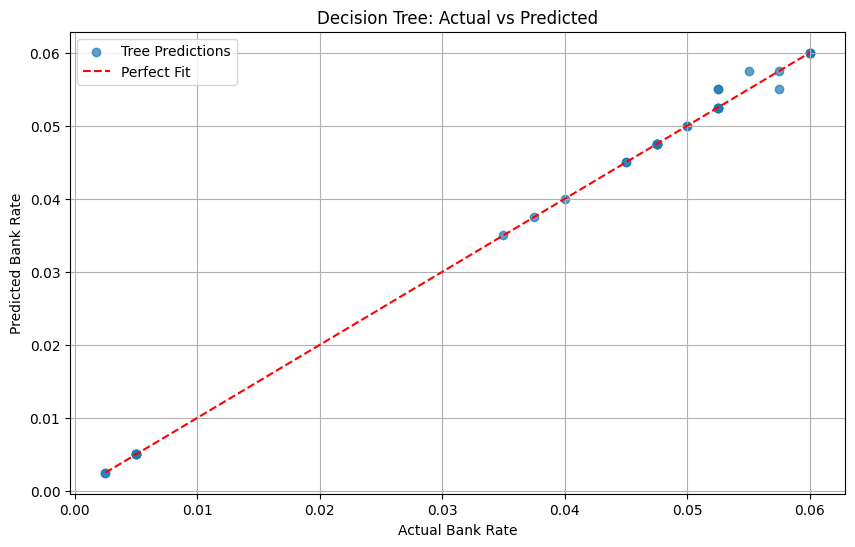

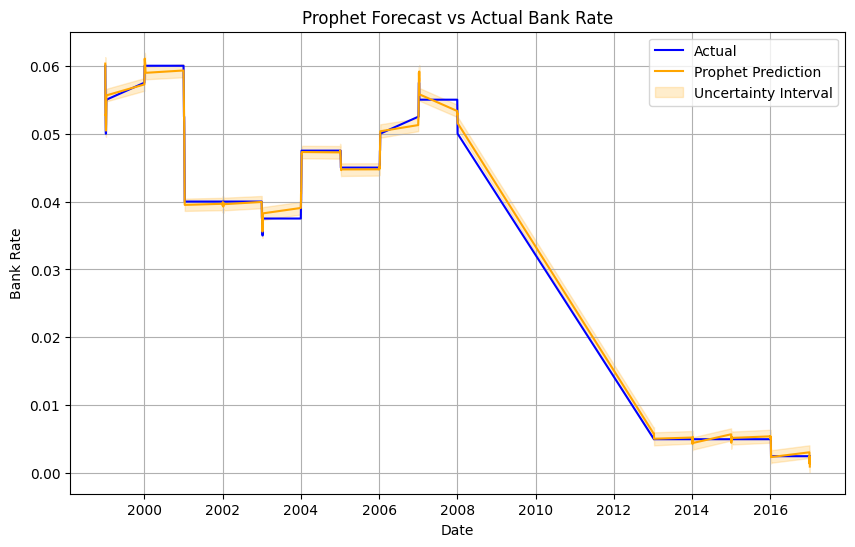

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from prophet import Prophet
import logging

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- Data Loading and Preprocessing ---
data = pd.read_csv('uk.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.dropna()

# --- Features and Target ---
features = [
    'Fixed_Rate_2y_95%_LTV',
    'Fixed_Rate_2y_75%_LTV',
    'Tracker',
    'Variable Rate',
    'LIBOR_3m',
    'Gov_Bond_Yield_10y'
]
X = data[features]
y = data['Bank_Rate']

# --- Scaling Features ---normalize karanna feature value 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/Test Split for Decision Tree ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Grid Search for Decision Tree --- meke tamai implement kare 
param_grid = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
tree_model = grid_search.best_estimator_

logger.info(f"Best Decision Tree Parameters: {grid_search.best_params_}")
y_pred_tree = tree_model.predict(X_test)

# --- Evaluation Metrics ---
mse = mean_squared_error(y_test, y_pred_tree)
mae = mean_absolute_error(y_test, y_pred_tree)
r2 = r2_score(y_test, y_pred_tree)
logger.info(f"Decision Tree - MSE: {mse}, MAE: {mae}, R2: {r2}")

# --- Predict with Decision Tree ---
def predict_with_tree(input_data):
    logger.info(f"Tree Input: {input_data}")
    input_df = pd.DataFrame([input_data], columns=features)
    input_scaled = scaler.transform(input_df)
    prediction = tree_model.predict(input_scaled)[0]
    logger.info(f"Tree Prediction: {prediction}")
    return prediction

# --- Prophet Setup ---
# Add regressors to Prophet for more accurate predictions
prophet_data = data[['Date', 'Bank_Rate'] + features].rename(columns={'Date': 'ds', 'Bank_Rate': 'y'})
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth="linear"
)

# Add regressors to Prophet
for feature in features:
    prophet_model.add_regressor(feature)

# Fit Prophet model with regressors
prophet_model.fit(prophet_data)

# --- Predict with Prophet ---
def predict_with_prophet(input_date, input_features):
    input_date = pd.to_datetime(input_date)
    
    future_df = pd.DataFrame({
        'ds': [input_date],
        **{feature: [input_features[i]] for i, feature in enumerate(features)}
    })

    forecast_result = prophet_model.predict(future_df)
    yhat = forecast_result['yhat'].values[0]
    yhat_lower = forecast_result['yhat_lower'].values[0]
    yhat_upper = forecast_result['yhat_upper'].values[0]

    logger.info(f"Prophet Prediction: {yhat} | Bounds: [{yhat_lower}, {yhat_upper}]")
    return max(0, yhat), max(0, yhat_lower), max(0, yhat_upper)

# --- Combined Prediction ---
def combined_prediction(input_features, input_date):
    tree_prediction = predict_with_tree(input_features)
    prophet_prediction, prophet_lower, prophet_upper = predict_with_prophet(input_date, input_features)

    if prophet_prediction > 0:
        combined_rate = 0.6 * prophet_prediction + 0.4 * tree_prediction
    else:
        combined_rate = tree_prediction

    logger.info(f"Combined Prediction for {input_date}: {combined_rate}")
    return combined_rate, prophet_lower, prophet_upper

# --- Visualizations ---
def plot_predictions():
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_tree, alpha=0.7, label="Tree Predictions")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit")
    plt.title("Decision Tree: Actual vs Predicted")
    plt.xlabel("Actual Bank Rate")
    plt.ylabel("Predicted Bank Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_prophet_vs_actual():
    future = prophet_model.make_future_dataframe(periods=0)
    for feature in features:
        future[feature] = data[feature].values[-len(future):]  # Add feature values for forecast
    forecast = prophet_model.predict(future)

    plt.figure(figsize=(10, 6))
    plt.plot(prophet_data['ds'], prophet_data['y'], label="Actual", color="blue")
    plt.plot(forecast['ds'], forecast['yhat'], label="Prophet Prediction", color="orange")
    plt.fill_between(
        forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
        color="orange", alpha=0.2, label="Uncertainty Interval"
    )
    plt.title("Prophet Forecast vs Actual Bank Rate")
    plt.xlabel("Date")
    plt.ylabel("Bank Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Example Prediction ---
input_features = [9, 0.3, 2.2, 4.4, 5, 7]  # Example features
input_date = '2027-02-15'

try:
    tree_rate = predict_with_tree(input_features)
    prophet_rate, prophet_lower, prophet_upper = predict_with_prophet(input_date, input_features)
    final_rate, lower_bound, upper_bound = combined_prediction(input_features, input_date)

    logger.info(f"Final Rate: {final_rate} | Interval: [{lower_bound}, {upper_bound}]")
except Exception as e:
    logger.error(f"Prediction Error: {e}")

# --- Visualize ---
plot_predictions()
plot_prophet_vs_actual()
